# Libraries

In [1]:
import pandas as pd
import numpy as np
import optuna
import plotly
from optuna.visualization import plot_contour, plot_edf, plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate
from optuna.visualization import plot_param_importances, plot_rank, plot_slice, plot_timeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from math import sqrt

pd.set_option('display.max_columns', None)

# Functions

In [2]:
def na_columns(df):
    na_count_per_column = df.isna().sum()
    return na_count_per_column

# Data loading

In [3]:
fixture = pd.read_csv('fixture.csv')
fixture.head()

,year,round,date,time,region,venue,hteam,ateam,hscore,ascore,is_grand_final,is_final,home_win,hdiff
0,2012,1,2012-03-31,16:45:00,WA,Subiaco,Fremantle,Geelong,105,101,0,0,1,4
1,2012,1,2012-03-31,15:45:00,QLD,Carrara,Gold Coast,Adelaide,68,137,0,0,0,-69
2,2012,1,2012-03-24,19:20:00,NSW,Stadium Australia,Greater Western Sydney,Sydney,37,100,0,0,0,-63
3,2012,1,2012-03-30,19:50:00,VIC,M.C.G.,Hawthorn,Collingwood,137,115,0,0,1,22
4,2012,1,2012-03-31,13:45:00,VIC,M.C.G.,Melbourne,Brisbane Lions,78,119,0,0,0,-41


In [4]:
na_columns(fixture)

year              0
round             0
date              0
time              0
region            0
venue             0
hteam             0
ateam             0
hscore            0
ascore            0
is_grand_final    0
is_final          0
home_win          0
hdiff             0
dtype: int64

In [5]:
fixture[fixture.isna().any(axis=1)]

,year,round,date,time,region,venue,hteam,ateam,hscore,ascore,is_grand_final,is_final,home_win,hdiff


# Data Prep

In [6]:
# convert to datetime dtype and extract month and day
fixture['date'] = pd.to_datetime(fixture['date'])
fixture['month'] = fixture['date'].dt.month
fixture['day'] = fixture['date'].dt.day_name()

# convert day into group so that monday, tues, wed, and thurs are all counted as a weekday game.
fixture['day_group'] = fixture['day'].apply(lambda x:'Weekday' if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday'] else x)

# Removing colons and converting time to integer
fixture['time_int'] = fixture['time'].str.replace(':', '').astype(int) / 100
fixture['time_int'] = fixture['time_int'].astype(int)

# create a time group column to show the time floor div
fixture['time_group'] = (fixture['time_int'] - 1200) // 100

# convert dataframe to one-hot vector
fixture_oh = pd.get_dummies(fixture, columns=['region', 'hteam', 'ateam', 'day_group'], dtype='int')

# ordinal encode the year
encoder = OrdinalEncoder()
fixture_oh['year_encoded'] = encoder.fit_transform(fixture_oh[['year']])

fixture_oh.head()

,year,round,date,time,venue,hscore,ascore,is_grand_final,is_final,home_win,hdiff,month,day,time_int,time_group,region_ACT,region_CHN,region_NSW,region_NT,region_NZL,region_QLD,region_SA,region_TAS,region_VIC,region_WA,hteam_Adelaide,hteam_Brisbane Lions,hteam_Carlton,hteam_Collingwood,hteam_Essendon,hteam_Fremantle,hteam_Geelong,hteam_Gold Coast,hteam_Greater Western Sydney,hteam_Hawthorn,hteam_Melbourne,hteam_North Melbourne,hteam_Port Adelaide,hteam_Richmond,hteam_St Kilda,hteam_Sydney,hteam_West Coast,hteam_Western Bulldogs,ateam_Adelaide,ateam_Brisbane Lions,ateam_Carlton,ateam_Collingwood,ateam_Essendon,ateam_Fremantle,ateam_Geelong,ateam_Gold Coast,ateam_Greater Western Sydney,ateam_Hawthorn,ateam_Melbourne,ateam_North Melbourne,ateam_Port Adelaide,ateam_Richmond,ateam_St Kilda,ateam_Sydney,ateam_West Coast,ateam_Western Bulldogs,day_group_Friday,day_group_Saturday,day_group_Sunday,day_group_Weekday,year_encoded
0,2012,1,2012-03-31,16:45:00,Subiaco,105,101,0,0,1,4,3,Saturday,1645,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0
1,2012,1,2012-03-31,15:45:00,Carrara,68,137,0,0,0,-69,3,Saturday,1545,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0
2,2012,1,2012-03-24,19:20:00,Stadium Australia,37,100,0,0,0,-63,3,Saturday,1920,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0
3,2012,1,2012-03-30,19:50:00,M.C.G.,137,115,0,0,1,22,3,Friday,1950,7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0
4,2012,1,2012-03-31,13:45:00,M.C.G.,78,119,0,0,0,-41,3,Saturday,1345,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0


In [7]:
fixture['day_group'].unique()

array(['Saturday', 'Friday', 'Sunday', 'Weekday'], dtype=object)

# Regression Modelling

In [8]:
# Define your features and target variable
X = fixture_oh.drop(['home_win', 'ascore', 'hscore', 'hdiff', 'date', 'time', 'venue', 'time_int', 'year', 'day'], axis=1)
y = fixture_oh['hdiff']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=42)

In [9]:
X_train.head()

,round,is_grand_final,is_final,month,time_group,region_ACT,region_CHN,region_NSW,region_NT,region_NZL,region_QLD,region_SA,region_TAS,region_VIC,region_WA,hteam_Adelaide,hteam_Brisbane Lions,hteam_Carlton,hteam_Collingwood,hteam_Essendon,hteam_Fremantle,hteam_Geelong,hteam_Gold Coast,hteam_Greater Western Sydney,hteam_Hawthorn,hteam_Melbourne,hteam_North Melbourne,hteam_Port Adelaide,hteam_Richmond,hteam_St Kilda,hteam_Sydney,hteam_West Coast,hteam_Western Bulldogs,ateam_Adelaide,ateam_Brisbane Lions,ateam_Carlton,ateam_Collingwood,ateam_Essendon,ateam_Fremantle,ateam_Geelong,ateam_Gold Coast,ateam_Greater Western Sydney,ateam_Hawthorn,ateam_Melbourne,ateam_North Melbourne,ateam_Port Adelaide,ateam_Richmond,ateam_St Kilda,ateam_Sydney,ateam_West Coast,ateam_Western Bulldogs,day_group_Friday,day_group_Saturday,day_group_Sunday,day_group_Weekday,year_encoded
1925,13,0,0,6,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9.0
1846,4,0,0,4,7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,9.0
279,9,0,0,5,7,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.0
43,5,0,0,4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0
729,14,0,0,7,7,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,3.0


In [10]:
# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [11]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

Mean Squared Error (MSE): 1722.7632858276368
Root Mean Squared Error (RMSE): 41.5061837058966
Mean Absolute Error (MAE): 32.83142538265306
R-squared: 0.028106002928966922


### KNN Regressor

Use the validation error. 

In [364]:
rmse_val = [] #to store rmse values for different k
for K in range(40):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test, pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 58.01435431100176
RMSE value for k=  2 is: 50.05165698902424
RMSE value for k=  3 is: 46.713931361211245
RMSE value for k=  4 is: 45.08186148212912
RMSE value for k=  5 is: 43.35197568644787
RMSE value for k=  6 is: 44.04292252954282
RMSE value for k=  7 is: 43.471760977661795
RMSE value for k=  8 is: 42.09945252685864
RMSE value for k=  9 is: 42.37421205540823
RMSE value for k=  10 is: 42.3148866553257
RMSE value for k=  11 is: 42.15901837278539
RMSE value for k=  12 is: 41.72926420307103
RMSE value for k=  13 is: 41.88054991636267
RMSE value for k=  14 is: 42.06611533220086
RMSE value for k=  15 is: 42.16279818774376
RMSE value for k=  16 is: 41.86441230755715
RMSE value for k=  17 is: 42.01068694928363
RMSE value for k=  18 is: 42.200965528759966
RMSE value for k=  19 is: 41.997224575766744
RMSE value for k=  20 is: 42.03500399933952
RMSE value for k=  21 is: 42.19044087159345
RMSE value for k=  22 is: 42.245782603099634
RMSE value for k=  23 is: 42.18126327

In [365]:
from sklearn.model_selection import GridSearchCV

K_lst = [i for i in range(2, 201)]  # 2 to 50
params = {'n_neighbors': K_lst}

knn = KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=3)
model.fit(X_train, y_train)
model.best_params_

{'n_neighbors': 147}

In [316]:
knn_model = KNeighborsRegressor(n_neighbors=104)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

# Evaluate the model
mse = sqrt(mean_squared_error(y_test, y_pred))
print("Mean Squared Error:", mse)

Mean Squared Error: 41.9310018775075


### Random Forest

In [272]:
from sklearn.ensemble import RandomForestRegressor

# You can adjust n_estimators, max_depth, and other parameters as needed
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [301]:
# https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
# Define the parameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [3, 5, 10, 20, 50, 100, 200],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 10, 50, 100]
}

# Initialize the grid search model
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)
print("R-squared on Test Set:", r2)

Fitting 3 folds for each of 84 candidates, totalling 252 fits
Best parameters: {'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.09253094601016836
Mean Squared Error on Test Set: 1420.7380986293842
Root Mean Squared Error on Test Set: 37.692679642463524
R-squared on Test Set: 0.20575780944475963


In [278]:
def objective(trial):
    # Define the hyperparameters' search space
    n_estimators = trial.suggest_categorical('n_estimators', [10, 50, 100, 200, 300, 400, 500, 600])
    max_depth = trial.suggest_categorical('max_depth', [10, 20, 30, 40, 50, 60])

    # Create and train the model
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)

    # Make predictions and calculate the error
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)

    return mse

# Create a study object and specify direction as 'minimize' for MSE
study = optuna.create_study(direction='minimize')

# Perform optimization
study.optimize(objective, n_trials=50)  # Number of trials is combinations of hyperparameters

[I 2023-12-21 04:34:49,556] A new study created in memory with name: no-name-4eebd269-9b12-44f6-b991-06c8603a038e
[I 2023-12-21 04:34:50,925] Trial 0 finished with value: 1374.2441946210758 and parameters: {'n_estimators': 300, 'max_depth': 30}. Best is trial 0 with value: 1374.2441946210758.
[I 2023-12-21 04:34:51,379] Trial 1 finished with value: 1336.0097627302973 and parameters: {'n_estimators': 100, 'max_depth': 30}. Best is trial 1 with value: 1336.0097627302973.
[I 2023-12-21 04:34:51,429] Trial 2 finished with value: 1414.3189436619718 and parameters: {'n_estimators': 10, 'max_depth': 50}. Best is trial 1 with value: 1336.0097627302973.
[I 2023-12-21 04:34:51,478] Trial 3 finished with value: 1454.9891551951528 and parameters: {'n_estimators': 10, 'max_depth': 30}. Best is trial 1 with value: 1336.0097627302973.
[I 2023-12-21 04:34:51,939] Trial 4 finished with value: 1342.944115523445 and parameters: {'n_estimators': 100, 'max_depth': 30}. Best is trial 1 with value: 1336.0097

[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=   1.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=10, mi

[I 2023-12-21 04:35:20,857] Trial 43 finished with value: 1346.9479648540528 and parameters: {'n_estimators': 200, 'max_depth': 20}. Best is trial 9 with value: 1329.0933198748046.


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=   0.8s
[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=   0.8s
[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=20, 

[I 2023-12-21 04:35:21,647] Trial 44 finished with value: 1364.5713465174679 and parameters: {'n_estimators': 200, 'max_depth': 20}. Best is trial 9 with value: 1329.0933198748046.


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END max_depth=30, min_samples_split=10, n_estimators=300; total time=   0.8s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END max_depth=30, min_samples_split=10, n_estimators=300; total time=   0.9s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END max_depth=30, min_samples_split=10, n_estimators=300; total time=   0.9s


[I 2023-12-21 04:35:22,570] Trial 45 finished with value: 1350.5673003380161 and parameters: {'n_estimators': 200, 'max_depth': 40}. Best is trial 9 with value: 1329.0933198748046.
[I 2023-12-21 04:35:23,270] Trial 46 finished with value: 1394.4100140917883 and parameters: {'n_estimators': 300, 'max_depth': 10}. Best is trial 9 with value: 1329.0933198748046.
[I 2023-12-21 04:35:24,220] Trial 47 finished with value: 1331.044214964789 and parameters: {'n_estimators': 200, 'max_depth': 60}. Best is trial 9 with value: 1329.0933198748046.
[I 2023-12-21 04:35:25,149] Trial 48 finished with value: 1370.063700528169 and parameters: {'n_estimators': 200, 'max_depth': 60}. Best is trial 9 with value: 1329.0933198748046.
[I 2023-12-21 04:35:26,103] Trial 49 finished with value: 1371.9656985915494 and parameters: {'n_estimators': 200, 'max_depth': 60}. Best is trial 9 with value: 1329.0933198748046.


In [279]:
# Best hyperparameters
print('Best hyperparameters:', study.best_params)

Best hyperparameters: {'n_estimators': 300, 'max_depth': 60}


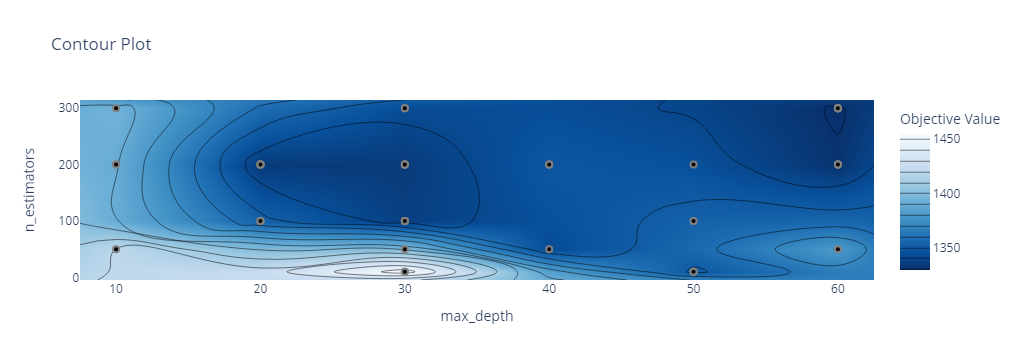

In [280]:
plot_contour(study)

/tmp/ipykernel_21/3430271029.py:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



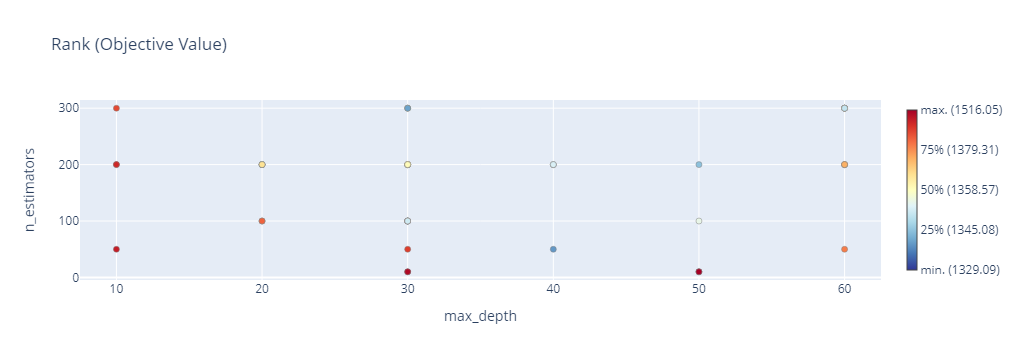

In [282]:
plot_rank(study)

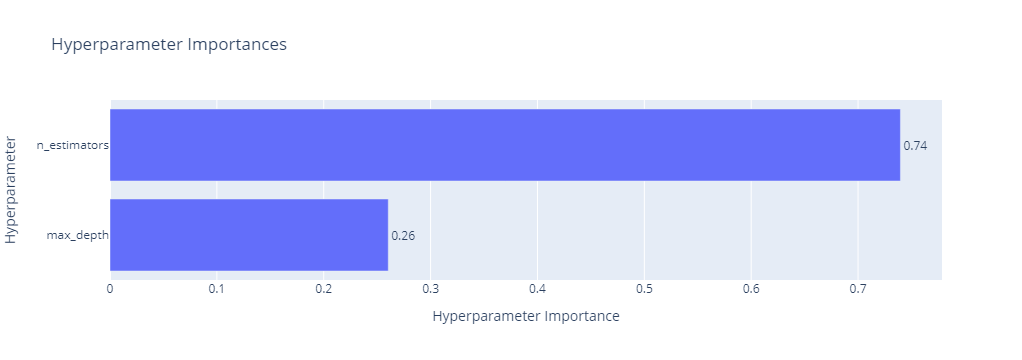

In [283]:
plot_param_importances(study)

# Classifier Modeling

## Logistic Regression Model

In [12]:
# Define your features and target variable
X = fixture_oh.drop(['home_win', 'ascore', 'hscore', 'hdiff', 'date', 'time', 'venue', 'time_int', 'year', 'day'], axis=1)
y = fixture_oh['home_win']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=42)

In [13]:
y_val.shape

(221,)

In [14]:
# Create and fit the model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [15]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.36      0.43       105
           1       0.61      0.76      0.68       140

    accuracy                           0.59       245
   macro avg       0.57      0.56      0.55       245
weighted avg       0.58      0.59      0.57       245



### Optuna Logistic Regression

In [16]:
def objective(trial):
    
    solver = 'lbfgs'
    # Suggest a value for C
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)

    # Model definition
    model = LogisticRegression(max_iter=1000, C=C, solver='lbfgs')

    # Fit model
    model.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

In [486]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

[I 2023-12-21 06:02:00,022] A new study created in memory with name: no-name-0a83d656-f30a-4679-a266-8d967b75f9bc
[I 2023-12-21 06:02:00,111] Trial 0 finished with value: 0.5429864253393665 and parameters: {'C': 0.10026300859956709}. Best is trial 0 with value: 0.5429864253393665.
[I 2023-12-21 06:02:00,149] Trial 1 finished with value: 0.5248868778280543 and parameters: {'C': 0.0002004478792404313}. Best is trial 0 with value: 0.5429864253393665.
[I 2023-12-21 06:02:00,318] Trial 2 finished with value: 0.5384615384615384 and parameters: {'C': 80.42095755916775}. Best is trial 0 with value: 0.5429864253393665.
[I 2023-12-21 06:02:00,338] Trial 3 finished with value: 0.5248868778280543 and parameters: {'C': 0.001232744419942421}. Best is trial 0 with value: 0.5429864253393665.
[I 2023-12-21 06:02:00,446] Trial 4 finished with value: 0.5248868778280543 and parameters: {'C': 1.1002929238307004}. Best is trial 0 with value: 0.5429864253393665.
[I 2023-12-21 06:02:00,490] Trial 5 finished w

/tmp/ipykernel_21/3430271029.py:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



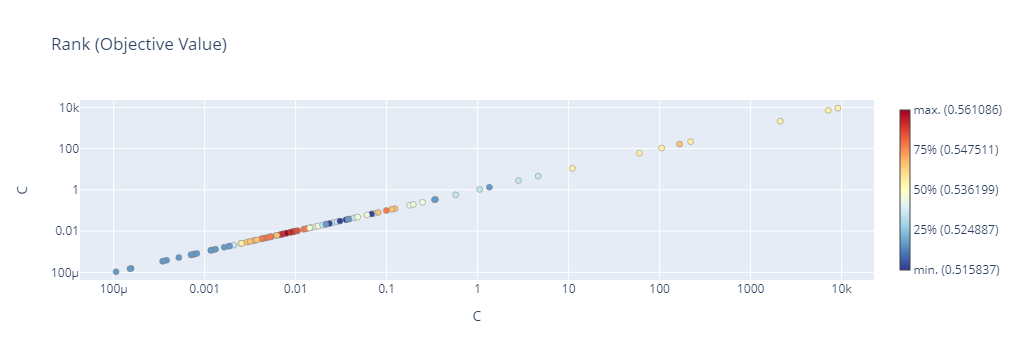

In [451]:
plot_rank(study)

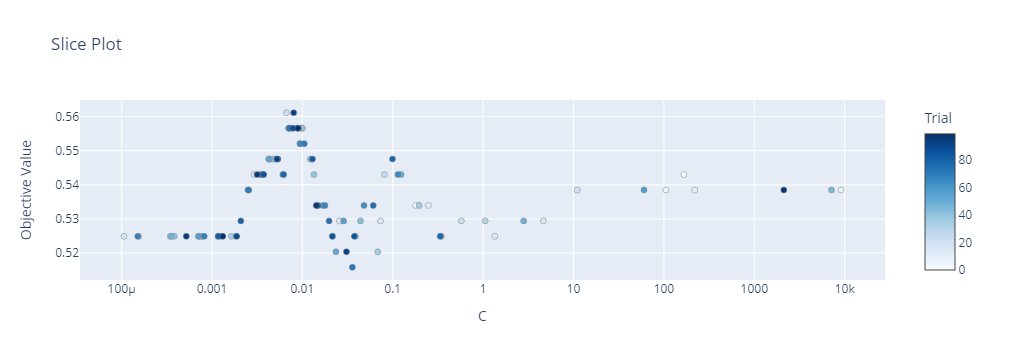

In [452]:
plot_slice(study)

In [453]:
# Retrieve the best hyperparameters
best_params = study.best_params
print('Best parameters:', best_params)

Best parameters: {'C': 0.006661571524532892}


In [454]:
# Create and fit the model
model = LogisticRegression(max_iter=1000, **best_params)
model.fit(X_train, y_train)

LogisticRegression(C=0.006661571524532892, max_iter=1000)

In [455]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.06      0.10       105
           1       0.58      0.96      0.72       140

    accuracy                           0.58       245
   macro avg       0.56      0.51      0.41       245
weighted avg       0.56      0.58      0.46       245



## KNN Classifier

In [521]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 2)

model.fit(X_train, y_train)  # fit the model
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

In [522]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.78      0.57       105
           1       0.63      0.29      0.39       140

    accuracy                           0.50       245
   macro avg       0.54      0.53      0.48       245
weighted avg       0.56      0.50      0.47       245



In [524]:
accuracy_val = [] #to store rmse values for different k
for K in range(100):
    K = K+1
    model = KNeighborsClassifier(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_val.append(accuracy) #store rmse values
    print('Accuracy value for k =', K, 'is:', accuracy)

Accuracy value for k = 1 is: 0.4841628959276018
Accuracy value for k = 2 is: 0.47058823529411764
Accuracy value for k = 3 is: 0.4841628959276018
Accuracy value for k = 4 is: 0.43891402714932126
Accuracy value for k = 5 is: 0.4796380090497738
Accuracy value for k = 6 is: 0.45248868778280543
Accuracy value for k = 7 is: 0.46153846153846156
Accuracy value for k = 8 is: 0.4841628959276018
Accuracy value for k = 9 is: 0.497737556561086
Accuracy value for k = 10 is: 0.47058823529411764
Accuracy value for k = 11 is: 0.497737556561086
Accuracy value for k = 12 is: 0.5113122171945701
Accuracy value for k = 13 is: 0.5158371040723982
Accuracy value for k = 14 is: 0.5113122171945701
Accuracy value for k = 15 is: 0.5113122171945701
Accuracy value for k = 16 is: 0.48868778280542985
Accuracy value for k = 17 is: 0.5248868778280543
Accuracy value for k = 18 is: 0.502262443438914
Accuracy value for k = 19 is: 0.5248868778280543
Accuracy value for k = 20 is: 0.49321266968325794
Accuracy value for k = 21

In [525]:
K_lst = [i for i in range(2, 101)]  # 2 to 50
params = {'n_neighbors': K_lst}

knn = KNeighborsClassifier()

model = GridSearchCV(knn, params, cv=3)
model.fit(X_train, y_train)
model.best_params_

{'n_neighbors': 91}

In [528]:
knn_model = KNeighborsClassifier(n_neighbors=91)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5387755102040817
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=4; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s

### KNN Optuna

In [533]:
def objective(trial):
    
    solver = 'lbfgs'
    # Suggest a value for C
    n_neighbors = trial.suggest_int('n_neighbors', 2, 100)

    # Model definition
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Fit model
    knn_model.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = knn_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

In [534]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

[I 2023-12-21 06:21:19,385] A new study created in memory with name: no-name-4f933a2e-ee9e-4b1b-a6d3-1e297a9896fa
[I 2023-12-21 06:21:19,401] Trial 0 finished with value: 0.5520361990950227 and parameters: {'n_neighbors': 53}. Best is trial 0 with value: 0.5520361990950227.
[I 2023-12-21 06:21:19,415] Trial 1 finished with value: 0.5429864253393665 and parameters: {'n_neighbors': 34}. Best is trial 0 with value: 0.5520361990950227.
[I 2023-12-21 06:21:19,426] Trial 2 finished with value: 0.4796380090497738 and parameters: {'n_neighbors': 5}. Best is trial 0 with value: 0.5520361990950227.
[I 2023-12-21 06:21:19,438] Trial 3 finished with value: 0.5113122171945701 and parameters: {'n_neighbors': 15}. Best is trial 0 with value: 0.5520361990950227.
[I 2023-12-21 06:21:19,451] Trial 4 finished with value: 0.5294117647058824 and parameters: {'n_neighbors': 21}. Best is trial 0 with value: 0.5520361990950227.
[I 2023-12-21 06:21:19,462] Trial 5 finished with value: 0.5339366515837104 and pa

In [535]:
# Retrieve the best hyperparameters
best_params = study.best_params
print('Best parameters:', best_params)

Best parameters: {'n_neighbors': 70}


In [536]:
# Create and fit the model
model = KNeighborsClassifier(**best_params)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=70)

In [537]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.16      0.22       105
           1       0.56      0.79      0.65       140

    accuracy                           0.52       245
   macro avg       0.46      0.47      0.44       245
weighted avg       0.47      0.52      0.47       245



In [17]:
105 / (140 + 105)

0.42857142857142855